# A2: Image classification in the browser

In this assignment, you will gain real-world experience with image classification on small datasets - a common scenario in practice. There are three parts.

1. First, you will train a model on a small existing dataset.

2. Next,  you will collect a small dataset yourself. Of course, in practice there isn’t often a dataset available for tasks you care about, so it’s valuable to get a feel for this process. You will train a small model from scratch, then use data augmentation to improve accuracy.

3. Finally, you will deploy your model from part two in a webpage using TensorFlow.js. A user will be able to upload a photo, and your model will classify it.

## Instructions

Please complete this notebook by searching for **"TODO"**.

## Submission instructions

Please submit this assignment on CourseWorks by uploading a Jupyter notebook that includes saved output. If you are working in Colab, you can prepare your notebook for submission by ensuring that runs end-to-end, then saving and downloading it:

1. ```Runtime -> Restart and run all```
1. ```File -> Save```
1. ```File -> Download.ipynb```

Note: you will need to include a URL to your webpage for part 3, see the final TODO at the bottom of this notebook.

## Setup instructions
1. If you are running this notebook in Colab, make sure a GPU is enabled (```Edit -> Notebook settings -> Hardware accelerator```).

2. Create a GitHub Pages repo by following the instructions at https://pages.github.com/. You may use this to host your webpage.

In [0]:
try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0-rc2


## 1a) Flowers

In this part of the assignment, you will train a model on a small existing dataset (flowers).

In [0]:
import IPython.display as display
import matplotlib.pyplot as plt
import random
import time

from tensorflow.keras import datasets, layers, models

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 192
SHUFFLE_SIZE = 1000

### Download the flowers dataset

In [0]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228818944/228813984 [==============================] - 2s 0us/step
/root/.keras/datasets/flower_photos


### Write an input pipeline from scratch
There are several ways to load images in TensorFlow. Later in this assignment, you'll use the [Keras preprocessing utilities](https://keras.io/preprocessing/image/). For starters, though, you'll write your own using ```tf.data```, based on this [tutorial](https://www.tensorflow.org/beta/tutorials/load_data/images). This is valuable to do once (just so you can see how the nuts and bolts work) before using the higher level utils. A bunch of the code is written for you, there are only a couple of TODOs. Follow along, though, and try to understand each piece.


In [0]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [0]:
all_image_paths[:5]

['/root/.keras/datasets/flower_photos/daisy/3475870145_685a19116d.jpg',
 '/root/.keras/datasets/flower_photos/tulips/4612075317_91eefff68c_n.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/5999024446_5721493894.jpg',
 '/root/.keras/datasets/flower_photos/dandelion/149782934_21adaf4a21.jpg',
 '/root/.keras/datasets/flower_photos/roses/3203779656_3580151ea4_m.jpg']

### Get to know your data

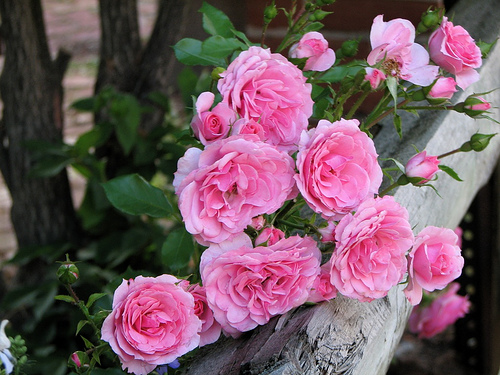

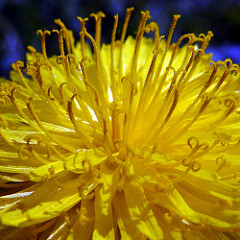

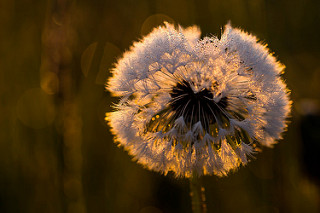

In [0]:
from IPython.display import Image
for n in range(3):
  image_path = random.choice(all_image_paths)
  #display.display(display.Image(image_path))
  display.display(Image(image_path))
  print()

### Classes are given by directory names

In [0]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [0]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [0]:
all_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_labels[:10])

First 10 labels indices:  [1, 0, 1, 3, 4, 0, 4, 3, 1, 4]


### Create a train/test split

In [0]:
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels)   

In [0]:
train_paths[0]

'/root/.keras/datasets/flower_photos/sunflowers/8174972548_0051c2d431.jpg'

### Display a few images and their labels

dandelion


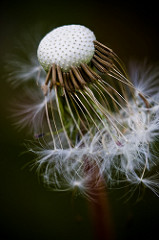


roses


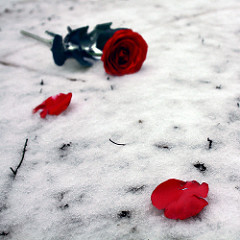


roses


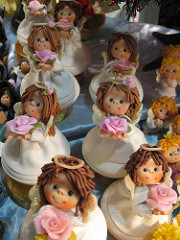

In [0]:
for n in range(3):
  i = random.randint(0,len(train_paths))
  image_path = train_paths[i]
  print(label_names[train_labels[i]])
  display.display(display.Image(image_path))
  print()

### Begin using TensorFlow ops to read and decode the images

In [0]:
img_raw = tf.io.read_file(train_paths[0])
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\...


In [0]:
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)

(331, 500, 3)
<dtype: 'uint8'>


In [0]:
img_final = tf.image.resize(img_tensor, [IMG_SIZE, IMG_SIZE])
img_final = img_final / 255.0 # normalize pixel values
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


### Wrap those in a function
Tip: pay careful attention to the preprocessing. When you deploy models in the browser, you will need to ensure that images are preprocessed identically in JavaScript as they are in Python.

In [0]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0  # normalize to [0,1] range
  return img

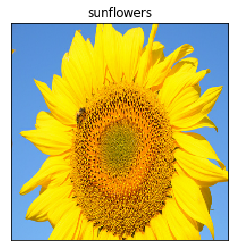

In [0]:
def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  print()

img_path = train_paths[0]
img = load_and_preprocess_image(img_path)
label = label_names[train_labels[0]]
show(img, label)

### Build an input pipeline to return images and labels
I realize this is complicated. The problem we're trying to solve using tf.data is performance (we want our preprocessing to run in C, but to write our code in Python). There are a bunch of advanced tricks you can do with tf.data as well (e.g. prefetching images to the GPU).

Note: although your *peak* performance can be higher, it's also very easy to make mistakes and end up with code that's super slow. Always benchmark your input pipelines before using them (shown in a bit). 

In [0]:
# a dataset that returns image paths
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
for n, img_path in enumerate(path_ds.take(4)):
  print(n, img_path)

0 tf.Tensor(b'/root/.keras/datasets/flower_photos/sunflowers/8174972548_0051c2d431.jpg', shape=(), dtype=string)
1 tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/23095658544_7226386954_n.jpg', shape=(), dtype=string)
2 tf.Tensor(b'/root/.keras/datasets/flower_photos/roses/4356781875_92c5cd93c0.jpg', shape=(), dtype=string)
3 tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/18684594849_7dd3634f5e_n.jpg', shape=(), dtype=string)


In [0]:
# a dataset that returns images (loaded off disk, decoded, and preprocessed)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
for n, image in enumerate(image_ds.take(4)):
  print(n, image.shape)

0 (192, 192, 3)
1 (192, 192, 3)
2 (192, 192, 3)
3 (192, 192, 3)


In [0]:
# a dataset that returns labels
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))
for label in label_ds.take(4):
  print(label_names[label.numpy()])

sunflowers
daisy
roses
daisy


In [0]:
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [0]:
for img, label in image_label_ds.take(2):
  print(img.shape, label_names[label.numpy()])

(192, 192, 3) sunflowers
(192, 192, 3) daisy


### Batch and shuffle
Why do we need to specify a shuffle_size parameter? tf.data works with streams (it doesn't know their length). To shuffle items, we maintain an in-memory buffer of this size.

In [0]:
ds = image_label_ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

for img, label in ds.take(2):
  print(img.shape, label.shape) # notice it's returning batches of data now

(32, 192, 192, 3) (32,)
(32, 192, 192, 3) (32,)


At this point, you could use the dataset above to train a model with ```model.fit(ds)``` but first, let's improve performance. As written, the dataset will load each image off disk, one at a time (super slow). Instead, we want to cache them in memory.

### Improve performance

In [0]:
# A benchmark utility to time how long it takes
# to iterate once over the entire dataset
def time_one_epoch(ds):
  start = time.time()
  batches = 0
  for i,(images,labels) in enumerate(ds):
    batches += 1
    if i % 10 == 0:
      print('.', end='')
  print()
  end = time.time()
  duration = end-start
  print("Read {} batches".format(batches))
  print("{:0.2f} Batches/s".format(batches/duration))
  print("{:0.2f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(duration))

### Use in-memory caching
This is a small dataset, so let's keep it in memory. The first time we iterate over this dataset, images will be loaded off disk, then cached. The first iteration will be quite slow, and subsequent ones will be faster. Let's show that. 

In [0]:
ds = image_label_ds.cache() # cache data in mempry
ds = ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [0]:
time_one_epoch(ds) # this will be slow

.........
Read 86 batches
15.18 Batches/s
485.62 Images/s
Total time: 5.666986465454102s


Now that the cache is built, iteration will be much faster.

In [0]:
time_one_epoch(ds) # this will be fast

.........
Read 86 batches
184.18 Batches/s
5893.84 Images/s
Total time: 0.46692848205566406s


If the dataset did not fit into memory, you could use a cache file on disk, like this:

```
ds = image_label_ds.cache(filename='./cache.tf-data')
ds = ds.shuffle(buffer_size=BUFFER_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
```

This can be useful to perform expensive preprocessing only once, and/or to improve file I/O (TF saves the cache file in an efficient format - it can be faster to read one large file than a bunch of small ones).

In [0]:
# here's our final training dataset
train_ds = image_label_ds.cache()
train_ds = train_ds.shuffle(SHUFFLE_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# let's make a test dataset as well
path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
test_ds = image_label_ds.cache().batch(BATCH_SIZE)

### Finally, we have a fast pipeline ready to go, written from scratch
Now, let's define a model.

## 1b) Create a simple CNN

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())
### TODO: your code here
# Add another pair of Conv2d and MaxPoolin2dD layers
# As the depth of the network increases, the images
# become smaller, and you can afford to use more 
# filters in each layer
###

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 93, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 32)        0         
Total params: 10,144
Trainable params: 10,144
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

### Tip: pay attention to the size of the model
Later, when you export a model to run in the webpage, you will want a small one (in terms of the number of parameters) that downloads quickly. Notice how much more efficient the convolutional layers are than the dense ones.

### Tip: pay attention to exactly how your images are preprocessed
Later, when you run your model in a browser, you'll need to preprocess images in Javascript in exactly the same way.

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 93, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 67712)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 338565    
Total params: 348,709
Trainable params: 348,709
Non-trainable params: 0
__________________________________________________

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# I realize we're using the test dataset (that's fine for this assignment)
model.fit(train_ds, validation_data=test_ds, epochs=10)

Epoch 1/10
86/86 [==============================] - 15s 174ms/step - loss: 1.3923 - accuracy: 0.4106 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
86/86 [==============================] - 5s 55ms/step - loss: 1.0121 - accuracy: 0.6061 - val_loss: 1.1886 - val_accuracy: 0.5490
Epoch 3/10
86/86 [==============================] - 5s 55ms/step - loss: 0.7913 - accuracy: 0.7053 - val_loss: 1.1532 - val_accuracy: 0.5414
Epoch 4/10
86/86 [==============================] - 5s 55ms/step - loss: 0.5348 - accuracy: 0.8205 - val_loss: 1.1752 - val_accuracy: 0.5686
Epoch 5/10
86/86 [==============================] - 5s 56ms/step - loss: 0.3056 - accuracy: 0.8983 - val_loss: 1.5008 - val_accuracy: 0.5643
Epoch 6/10
86/86 [==============================] - 5s 56ms/step - loss: 0.1727 - accuracy: 0.9520 - val_loss: 1.4764 - val_accuracy: 0.5708
Epoch 7/10
86/86 [==============================] - 5s 55ms/step - loss: 0.1055 - accuracy: 0.9753 - val_loss: 1.9374 - val_accuracy: 0.5468
Epo

### Make predictions on a single image
Tip: models are implemented to make predictions on batches of images for efficiency. This means that to make a prediction on a single image, you'll need to first wrap it in a batch. The syntax can feel a little unusual at first, but gets easier with time.

In [0]:
# load an image off disk
img_index = 0
img = load_and_preprocess_image(train_paths[img_index])

print(img.shape) # before

#########
## TODO: your code here
## use tf.expand_dims to create an empty batch dimension
## the starting image shape is (192, 192, 3)
## you want it to be (1, 192, 192, 3)
## that's read as "a batch of 1 image, with 192 rows, 192 cols, 
## and 3 color channels"
#########
im_batch = tf.expand_dims(img,axis=0) # YOUR CODE HERE, use tf.expand_dims

print(im_batch.shape) # after

# make predictions
batch_pred = model.predict(im_batch) # returns a list of predictions
pred = batch_pred[0] 

print("Prediction", label_names[tf.argmax(pred)])
print("Actual", label_names[train_labels[img_index]])

(192, 192, 3)
(1, 192, 192, 3)
Prediction sunflowers
Actual sunflowers


### TODO: Improve accuracy
Write a new model that's more accurate than the baseline above (the baseline has only one Conv2D and MaxPooling2D layer). Produce plots of loss / accuracy as a function of epochs. Train your model without overfitting. For this assignment, it is not necessary to build a super accurate model - just experiment a bit and try to improve over the baseline.

Epoch 1/5
86/86 [==============================] - 7s 76ms/step - loss: 1.4147 - accuracy: 0.4241 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
86/86 [==============================] - 6s 65ms/step - loss: 1.1583 - accuracy: 0.5523 - val_loss: 1.1718 - val_accuracy: 0.5697
Epoch 3/5
86/86 [==============================] - 6s 64ms/step - loss: 1.0363 - accuracy: 0.6141 - val_loss: 1.1231 - val_accuracy: 0.5501
Epoch 4/5
86/86 [==============================] - 6s 65ms/step - loss: 0.9101 - accuracy: 0.6730 - val_loss: 1.0713 - val_accuracy: 0.5784
Epoch 5/5
86/86 [==============================] - 6s 65ms/step - loss: 0.7839 - accuracy: 0.7293 - val_loss: 1.0617 - val_accuracy: 0.6046


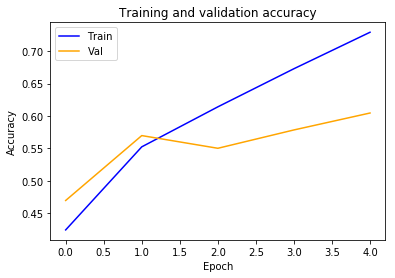

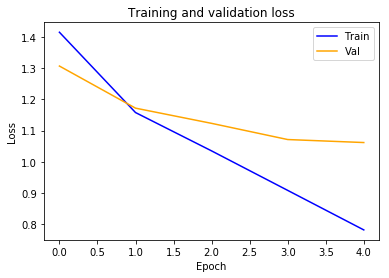

In [0]:
# TODO: your code here
new_model = models.Sequential()
new_model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.001), 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
new_model.add(layers.MaxPooling2D())
new_model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.001)))
new_model.add(layers.MaxPooling2D())
# Adding a third layer
new_model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.001)))
new_model.add(layers.MaxPooling2D())
new_model.add(layers.Flatten())
new_model.add(layers.Dropout(0.5))
new_model.add(layers.Dense(10, activation='softmax'))

new_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = new_model.fit(train_ds, validation_data=test_ds, epochs=5)
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot(history)

## 1c) Try to get your flowers model working in TensorFlow.js
In the final part of the assignment, you'll export the model you build to recognize landmarks on Columbia's campus, and get it working in the browser. It's easiest to start by exporting your flowers model, and getting it working with TensorFlow.js (the starter code is build around your flowers model, so you can learn the mechanics before trying something more complex).

### Save your model

In [0]:
!ls

gdrive	my_model.h5  sample_data


In [0]:
model.save("/content/my_model.h5")

In [0]:
!ls -lha

total 4.1M
drwxr-xr-x 1 root root 4.0K Oct 13 19:01 .
drwxr-xr-x 1 root root 4.0K Oct 13 15:54 ..
drwxr-xr-x 1 root root 4.0K Oct  8 20:06 .config
drwx------ 2 root root 4.0K Oct 13 18:09 gdrive
-rw-r--r-- 1 root root 4.1M Oct 13 19:49 my_model.h5
drwxr-xr-x 1 root root 4.0K Aug 27 16:17 sample_data


### Download it to your local machine

In [0]:
pwd

'/content'

In [0]:
from google.colab import files
files.download("/content/my_model.h5")

### Visit notebook #2 to convert it to TensorFlow.js format
Follow the instructions there to prepare a webpage to run your flowers model in the browser. Once you have that working, continue with the rest of this assignment.

## 1d) Transfer learning

In this part of the assignment, you'll use transfer learning to take advantage of a large pretrained model. It is not necesary to deploy this part in the browser.


References:
* https://www.tensorflow.org/beta/tutorials/images/transfer_learning

In [0]:
## TODO: your code here
# Choose a pretrained model, and import the application
# See https://keras.io/applications/ for a few choices
# When you import the model, you will want to remove the 
# final dense layer that performs classification (include_top=False)
# you will also want to import weights from ImageNet,
# and you will want to specify the input shape to match your images. 

# fix me. base_model = tf.keras.applications...
base_model = tf.keras.applications.resnet_v2
base_model = base_model.ResNet101V2(weights='imagenet', include_top=False)

In [0]:
# A hack to show you the output shape of the model
for image_batch, label_batch in train_ds.take(1):
   pass
  
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 2048)


In [0]:
# do not update the pretrained weights during training
# (we won't use finetuning here)
base_model.trainable = False 

In [0]:
base_model.summary()

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [0]:
# build a new model reusing the pretrained base
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
86/86 [==============================] - 44s 512ms/step - loss: 0.7950 - accuracy: 0.6959 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
86/86 [==============================] - 34s 393ms/step - loss: 0.4600 - accuracy: 0.8459 - val_loss: 1.0614 - val_accuracy: 0.6983
Epoch 3/5
86/86 [==============================] - 34s 393ms/step - loss: 0.3741 - accuracy: 0.8717 - val_loss: 0.9357 - val_accuracy: 0.7233
Epoch 4/5
86/86 [==============================] - 34s 393ms/step - loss: 0.3283 - accuracy: 0.8819 - val_loss: 0.9371 - val_accuracy: 0.7320
Epoch 5/5
86/86 [==============================] - 34s 392ms/step - loss: 0.2850 - accuracy: 0.9073 - val_loss: 0.9395 - val_accuracy: 0.7353


## 2a) Recognize landmarks on Columbia's campus

In this part of the assignment, you will train a model to recognize landmarks (famous places, like the [Alma Mater sculpture](https://en.wikipedia.org/wiki/Alma_Mater_(New_York_sculpture), or Butler library) on Columbia’s campus. Instead of tf.data, you will gain experience with the higher level Keras utilties. You will also experiment with data augmentation to increase the effective size of your dataset.

Starter code is not provided for this part of the assignment. You should base your work off the following Keras notebook, which works identically in TF2 (the only thing you'll need to change is the imports, an example of correct imports is given below).

* https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb

Here are steps you should complete.

1. Collect a dataset of at least three landmarks. Your dataset should include at least 50 images of each landmark in train, and 50 in validation (using more images is fine). Randomly shuffle your data to create these splits. You do not need to use a separate test set in this assignment.

 You will need to upload your dataset to Colab in order to train a model. To do so, you can either upload it using the file browser (slow and tedious, you'll need to repeat that if your runtime is reset), or (better) you can upload your dataset to Google Drive, then mount your drive as a filesystem in Colab (View -> Table of contents -> Code snippets -> search for "drive"). This will enable you to access the contents of your drive with commands like `!ls /gdrive`. As a another option, you could upload your dataset to a cloud provider or your Columbia account, then download it similarly to flowers at the top of this notebook.
 
1. Write a model to classify your data. Try to train a small model in terms of the number of parameters (you do not need to use transfer learning). 

1. Show predictions on several images.

1. Use data augmentation, see if this helps to improve accuracy.

1. Produce plots of accuracy / loss as a function of epochs. Determine the right place to stop training without overfitting.

When you have a reasonably accurate model, proceed to the next step. There are no guidelines for accuracy, try to build something you feel works well, given the small amount of data you have.

In [0]:
# Example code showing the correct imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Example code:
# You should use the keras preprocessing utilities here instead of tf.data
# Here's an example of how to use them with the flowers dataset
# You will need to add data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        data_root,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32)

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

###
# TODO: your code for 2a here.
###




Found 3670 images belonging to 5 classes.
data batch shape: (32, 192, 192, 3)
labels batch shape: (32, 5)


## Following are some steps to prepare the training and validation data from my Google Drive folder

### Install PyDrive

In [0]:
!pip install -U -q PyDrive

### Perform Google authentication

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Function that randomly selects indices from 0 to 100.
Based on the generated indices we select images from the folder for the training set. Rest of the images are put into Validation set.

In [0]:
# randomly generate 50 indices for goat_guy from 1 to 100
def generate_random_indices(training_dataset_num):
  indices = []
  while True:
    random_num = random.randint(0,100)
    if random_num in indices:
      continue
    else:
      indices.append(random_num)
      if len(indices) >= training_dataset_num:
        break
  return indices

### Renaming files
Image files generated using ffmpeg may have same names. So we run a method to rename the files so that none of them get overwritten when we move them to Training and Validation folders. Note that these changes are going to persist, so there's no need to re-run the following four operations.

In [0]:
# rename files in the folders
# import os
# def rename_files(folder_path, start_phrase):
#   for filename in os.listdir(folder_path):
#     current_path = folder_path + '/' + filename
#     new_path = folder_path + '/' + start_phrase + filename
#     os.rename(current_path, new_path)

In [0]:
#rename_files('My Drive/LandmarkTraining/Pan', 'pan')

In [0]:
#rename_files('My Drive/LandmarkTraining/The Curl', 'curl')

In [0]:
#rename_files('My Drive/LandmarkTraining/AlmaMater','alma')

### Preparing Training and Validation datasets
From the images in 3 different folders - Pan, The Curl and AlmaMater.
This procedure needs to run only once, so I have commented it out.

In [0]:
# import os
# import shutil
# def prepare_training_data(root_dir, num_indices):
#   random_indices = generate_random_indices(num_indices)
#   training_dir = 'My Drive/LandmarkTraining/Training'
#   validation_dir = 'My Drive/LandmarkTraining/Validation'
#   # pick files according to indices specified in the random_indices and transfer them to Training. Transfer remaining files 
#   # to Validation
#   index = 0
#   for filename in os.listdir(root_dir):
#       # because path is object not string
#       current_path = root_dir + '/' + filename
#       dest_path = ''
#       if index in random_indices:
#         dest_path = training_dir + '/' + filename
#         #  os.rename(current_path, dest_path)
#         #  shutil.move(current_path, dest_path)
#       else:
#         dest_path = validation_dir + '/' + filename
#       os.replace(current_path, dest_path)
#       index = index + 1


In [0]:
root_dir_pan = 'My Drive/LandmarkTraining/Pan'
root_dir_curl = 'My Drive/LandmarkTraining/The Curl'
root_dir_almamater = 'My Drive/LandmarkTraining/AlmaMater'


The following steps need to be done only once, so commenting them out. Keeping the code for reference only.

In [0]:
#prepare_training_data(root_dir_pan, 70)

In [0]:
#prepare_training_data(root_dir_curl, 52)

In [0]:
#prepare_training_data(root_dir_almamater, 60)

In [0]:
%cd /content/gdrive

/content/gdrive


### Creating the new model
without data augmentation

In [0]:
# from tensorflow.keras import layers
# from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 93, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 61952)             0

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Data Preprocessing

In [0]:
# training_dir = '/content/gdrive/My Drive/Training'
# validation_dir = '/content/gdrive/My Drive/Validation'

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        training_dir,
        # All images will be resized to 150x150
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32)

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 182 images belonging to 3 classes.
Found 173 images belonging to 3 classes.
data batch shape: (32, 192, 192, 3)
labels batch shape: (32, 3)


In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=10)

Epoch 1/30
5/5 [==============================] - 7s 1s/step - loss: 5.0456e-06 - accuracy: 1.0000 - val_loss: 0.0254 - val_accuracy: 0.9900
Epoch 2/30
5/5 [==============================] - 8s 2s/step - loss: 3.9401e-06 - accuracy: 1.0000 - val_loss: 0.0336 - val_accuracy: 0.9867
Epoch 3/30
5/5 [==============================] - 8s 2s/step - loss: 4.9062e-06 - accuracy: 1.0000 - val_loss: 0.0297 - val_accuracy: 0.9867
Epoch 4/30
5/5 [==============================] - 7s 1s/step - loss: 4.0077e-06 - accuracy: 1.0000 - val_loss: 0.0261 - val_accuracy: 0.9900
Epoch 5/30
5/5 [==============================] - 8s 2s/step - loss: 3.1866e-06 - accuracy: 1.0000 - val_loss: 0.0310 - val_accuracy: 0.9867
Epoch 6/30
5/5 [==============================] - 7s 1s/step - loss: 4.4333e-06 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 0.9934
Epoch 7/30
5/5 [==============================] - 6s 1s/step - loss: 3.7472e-06 - accuracy: 1.0000 - val_loss: 0.0293 - val_accuracy: 0.9867
Epoch 8/30
5/

In [0]:
model.save('/content/model_landmarks1.h5')

### Plotting accuracy and loss

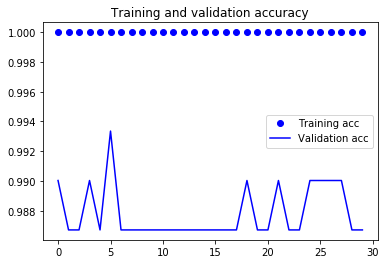

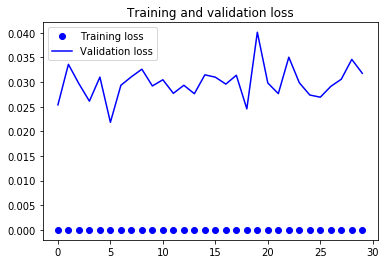

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Model with data augmentation

In [0]:
aug_model = models.Sequential()
aug_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
aug_model.add(layers.MaxPooling2D((2, 2)))
aug_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
aug_model.add(layers.MaxPooling2D((2, 2)))
aug_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
aug_model.add(layers.MaxPooling2D((2, 2)))
# aug_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# aug_model.add(layers.MaxPooling2D((2, 2)))
aug_model.add(layers.Flatten())
aug_model.add(layers.Dropout(0.5))
aug_model.add(layers.Dense(256, activation='relu'))
aug_model.add(layers.Dense(3, activation='softmax'))

aug_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Data preprocessing for the augmented model

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen_2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
test_datagen_2 = ImageDataGenerator(rescale=1./255)
train_generator_2 = train_datagen_2.flow_from_directory(
        # This is the target directory
        training_dir,
        # All images will be resized to 150x150
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32)

validation_generator_2 = test_datagen_2.flow_from_directory(
        validation_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32)

for data_batch, labels_batch in train_generator_2:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break



Found 182 images belonging to 3 classes.
Found 173 images belonging to 3 classes.
data batch shape: (32, 192, 192, 3)
labels batch shape: (32, 3)


### Fitting the augmented model

In [0]:
history_aug = aug_model.fit_generator(
      train_generator_2,
      steps_per_epoch=10,
      epochs=100,
      validation_data=validation_generator_2,
      validation_steps=10)

Epoch 1/100
10/10 [==============================] - 14s 1s/step - loss: 1.3583 - accuracy: 0.3645 - val_loss: 1.0878 - val_accuracy: 0.3821
Epoch 2/100
10/10 [==============================] - 13s 1s/step - loss: 0.9730 - accuracy: 0.4633 - val_loss: 0.6682 - val_accuracy: 0.6346
Epoch 3/100
10/10 [==============================] - 13s 1s/step - loss: 0.5826 - accuracy: 0.7667 - val_loss: 0.3802 - val_accuracy: 0.8007
Epoch 4/100
10/10 [==============================] - 10s 975ms/step - loss: 0.5409 - accuracy: 0.7100 - val_loss: 0.3478 - val_accuracy: 0.7874
Epoch 5/100
10/10 [==============================] - 13s 1s/step - loss: 0.4068 - accuracy: 0.8226 - val_loss: 0.4225 - val_accuracy: 0.7641
Epoch 6/100
10/10 [==============================] - 13s 1s/step - loss: 0.3742 - accuracy: 0.8233 - val_loss: 0.3940 - val_accuracy: 0.8505
Epoch 7/100
10/10 [==============================] - 10s 994ms/step - loss: 0.2690 - accuracy: 0.8967 - val_loss: 0.1021 - val_accuracy: 0.9568
Epoch 8

### Plotting accuracy and loss of the augmented model

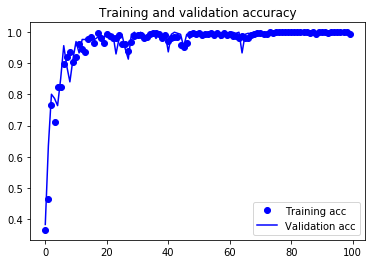

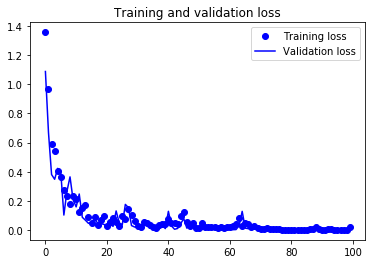

In [0]:
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Save the augmented model

In [0]:
model.save('/content/augmented_model.h5')

### Visualizing predictions on images

#### Get the class names

In [0]:
label_names = []
label_paths = [os.path.abspath(name) for name in os.listdir(training_dir)]
for label_path in label_paths:
  label_names.append(os.path.basename(label_path))
label_names

['Pan', 'TheCurl', 'AlmaMater']

In [0]:
# load an image off disk
img_index = 0
img = load_and_preprocess_image('/content/gdrive/My Drive/Training/TheCurl/curl18.jpg')

print(img.shape) # before
im_batch = tf.expand_dims(img,axis=0) # YOUR CODE HERE, use tf.expand_dims

print(im_batch.shape) # after

# make predictions
batch_pred = model.predict(im_batch) # returns a list of predictions
pred = batch_pred[0] 

print("Prediction", label_names[tf.argmax(pred)])
print("Actual", label_names[train_labels[img_index]])

(192, 192, 3)
(1, 192, 192, 3)
Prediction AlmaMater
Actual Pan


## 2b) Donate your dataset (optional)
We will use the dataset collected by the class later in the semester.

Requirements:

* Please do not include any images with people in the foreground.
* Only include images you have taken yourself and that you are comfortable sharing publicly under a [CCO](https://creativecommons.org/share-your-work/public-domain/cc0/) license (TLDR, public domain).

Link to upload a zip is on CourseWorks. Your file should be in the same format as the flowers dataset (the directory names gives the label for each image).



## 3) Run your model in the browser
Save and download your model, and head to notebook two again. After you've finished creating a webpage, upload it to GitHub pages or your Columbia account, list the URL here, and submit your assignment. You may not need to make many changes to the starter code, but pay attention to the preprocessing, number of output classes, image size, etc.

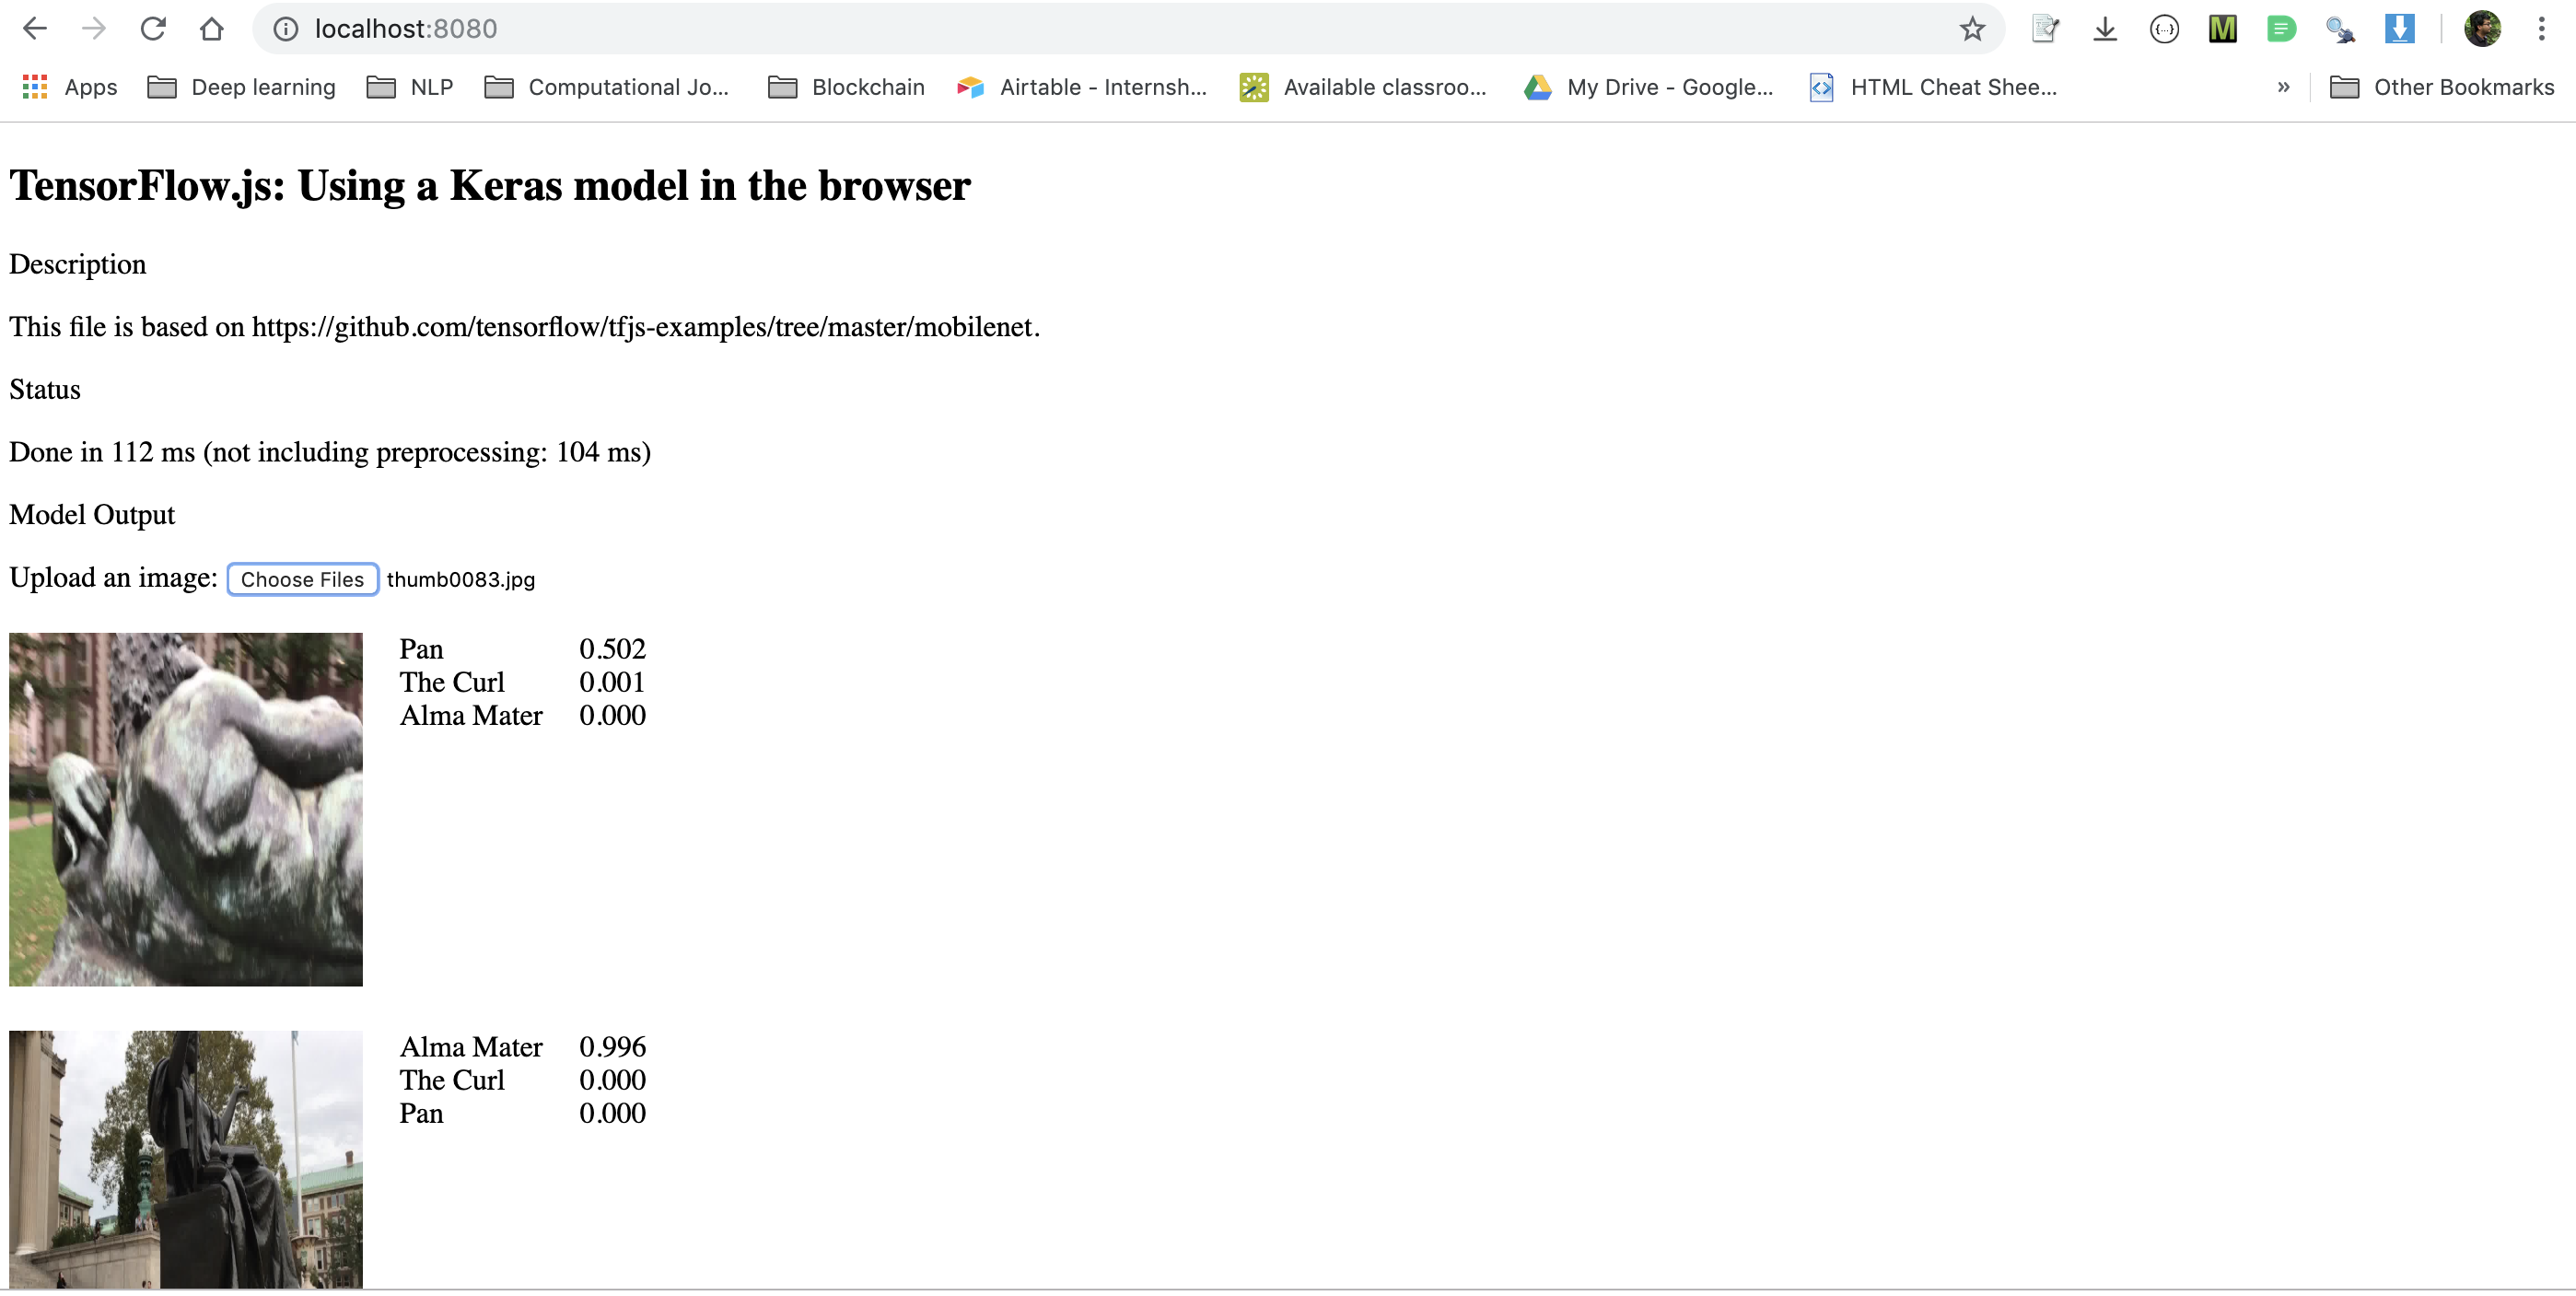

In [0]:
# TODO: http://your_webpage
# will provide screenshots
from IPython.core.display import display, Image
screenshot_path = '/content/gdrive/My Drive/ScreenShot.png'
display(Image(screenshot_path, height=500, width=1000))